# Proyecto 1

**Juan David Guevara Arévalo - 202116875**

**Yesid Steven Piñeros Piñeros - 202013148**

**Esteban Orjuela Perdomo - 202211227**

## Instalación de librerías

In [ ]:
%pip install pandas numpy matplotlib seaborn nltk scikit-learn scikit-plot scipy ydata-profiling unidecode

In [ ]:
import pandas as pd
import numpy as np
import sys

import re, string
import unidecode
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

In [ ]:
import nltk

nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

True

## Carga de datos

Primeramente se  cargan los datos en un data frame df:

In [ ]:
df = pd.read_csv("data/fake_news_spanish.csv", sep=";", encoding="utf-8")
df_test = pd.read_csv("data/fake_news_test.csv", sep=";", encoding="utf-8")

Ahora observamos una muestra de los primeros elementos de estos datos para dar una primera visualización:

In [ ]:
df.sample(10)

,ID,Label,Titulo,Descripcion,Fecha
1166,ID,1,Las ONG feministas preparan protestas mientras...,"La consejera de Igualdad, de Ciudadanos, en me...",17/01/2020
22907,ID,0,Carmen Calvo: '¿Por qué lo que es bueno para l...,El todavía candidato de PP pide a partido reca...,20/01/2019
7039,ID,0,Supermercados públicos y transporte gratuito: ...,El partido presenta este sábado el programa ma...,06/05/2023
32355,ID,0,"El vicepresidente andaluz, de Cs, apoya la dec...",Marín ha manifestado ha valorado la decisión d...,10/10/2020
11627,ID,0,Moncloa contenta al sector inmobiliario con su...,El Presidente del Gobierno ha recibido el vist...,08/05/2023
34635,ID,1,Recuperar Barcelona y convertirse en la primer...,Superada la profunda crisis que sufrió durante...,21/06/2022
45139,ID,0,La Fiscalía pide la detención internacional de...,El Ministerio Público no se ha pronunciado sob...,31/10/2019
1794,ID,0,Lista continuista de Barcelona en Comú para la...,"Los concejales Gemma Tarafa, Lucía Martín, Mar...",11/02/2023
22388,ID,0,El CGPJ abre un expediente disciplinario por f...,El promotor de la Acción disciplinaria del Con...,23/03/2023
41426,ID,1,"El Gobierno pide 'lealtad, responsabilidad y m...","Quien quiera trabajar con nosotros, bienvenido...",09/05/2018


# Sección 1 Documentación del proceso de aprendizaje automático.

## Canva:

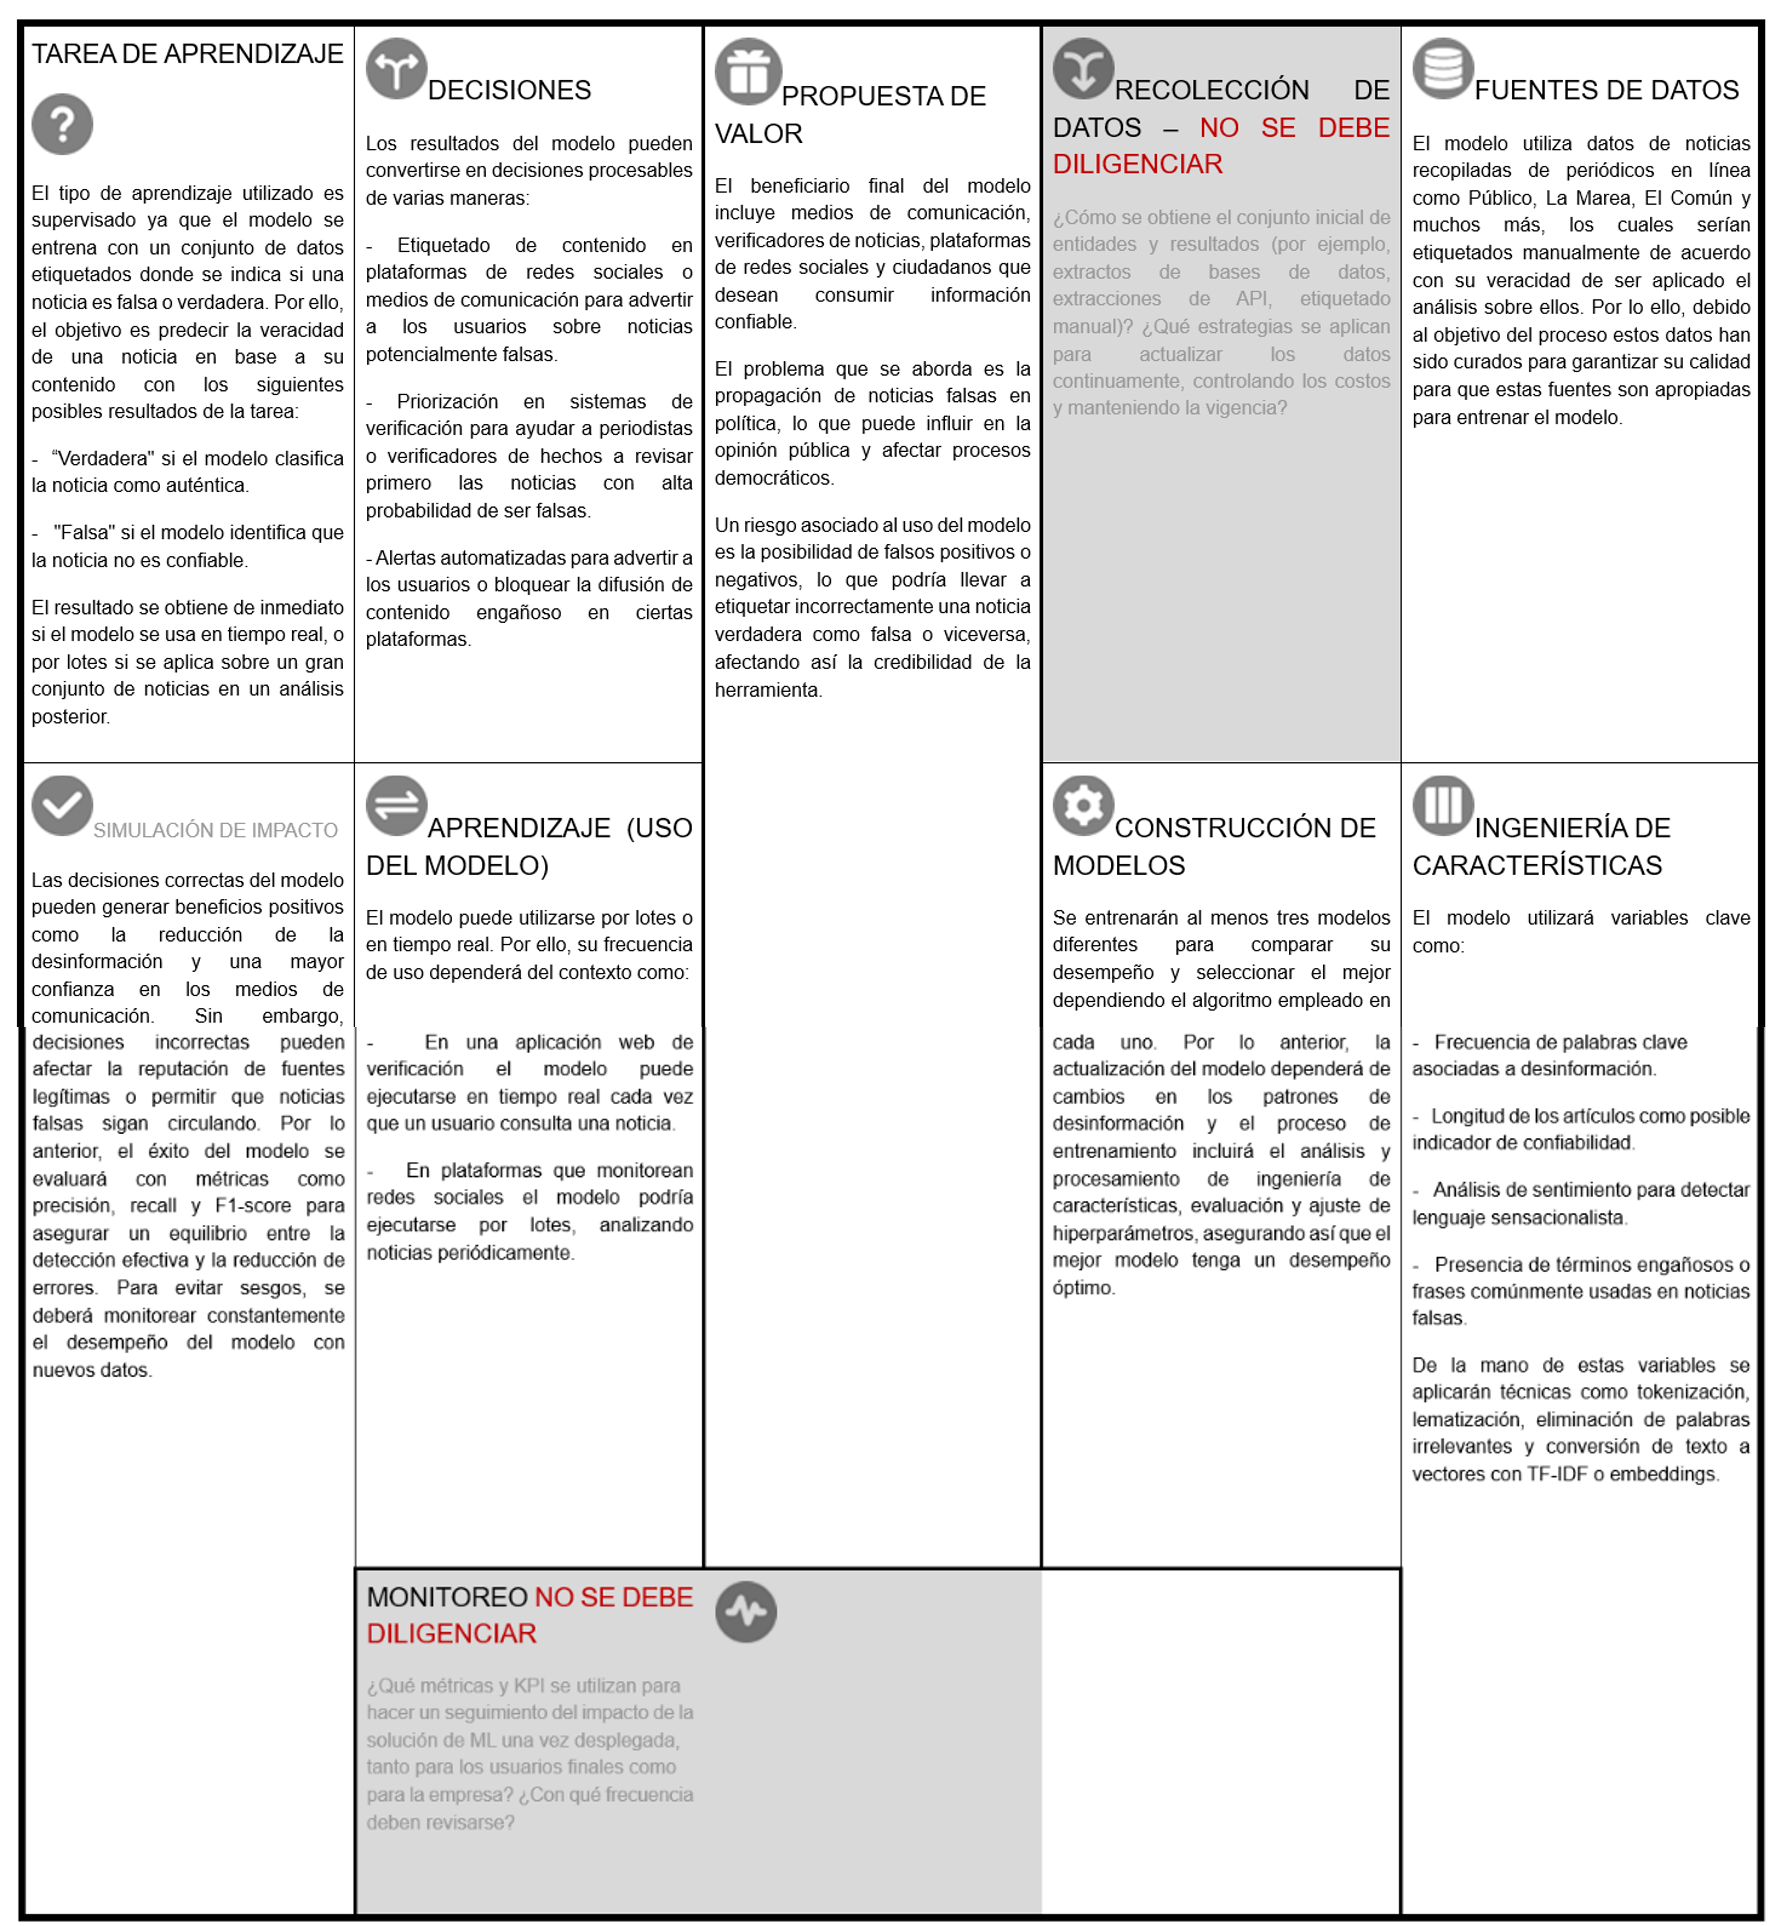


# Sección 2 Entendimiento y preparación de los datos.

## 1.2 Limpieza de datos

**Completitud**

Buscamos registros con valores faltantes y decidir, desde el contexto del negocio, que se puede hacer con ellos. Por lo general podemos:
* Eliminar
* Reemplazar


Primero observamos que columnas tienen datos faltantes:

In [ ]:
df_porcentajes = (100*df.isna().sum()/len(df)).to_frame()
df_porcentajes.sort_values(0, ascending = False)

,0
Titulo,0.028039
ID,0.000000
Label,0.000000
Descripcion,0.000000
Fecha,0.000000


Se decide eliminar las filas que tengan titulos con valores faltantes, pues textos sin títulos podrían indicar informacion de mala calidad o de fuentes poco confiables. Mantenemos el df original y creamos una copia en donde hacemos la limpieza.

In [ ]:
texts_test = df_test.copy()
texts = df.copy()
texts = texts.dropna(subset=["Titulo"])

**Primero hacemos un procesamiento del texto para que no influyan las mayusculas, puntuacion entre otras cosas que pueden alterar o agregar ruido, ya que posteriormente vamos a buscar casos de duplicados y podrian haber por ejemplo un documento con el mismo titulo que el otro pero que cambie una mayuscula o alguna puntuación.**

Para esto definimos funciones que precisamente reemplacen todo el texto a minusculas y sin puntuación, adicionalmente que eliminen las llamadas "stop words":

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unidecode.unidecode(word)
          new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    sw = set(stopwords.words('spanish'))
    for word in words:
        if word not in sw:
            new_words.append(word)
    return new_words


def preprocessing(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [ ]:
texts_test["full_text"] = texts_test["Descripcion"].apply(word_tokenize)
texts_test["full_text"] = texts_test["full_text"].apply(preprocessing)
texts_test

,ID,Titulo,Descripcion,Fecha,full_text
0,ID,La mesa del congreso censura un encuentro inte...,"Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...",30/10/2018,"[portavoces, ciudadanos, pnv, upn, psoe, unido..."
1,ID,La brecha digital que dificulta el acceso de a...,No es la primera vez que los ciudadanos vulner...,15/03/2023,"[primera, vez, ciudadanos, vulnerables, topan,..."
2,ID,PP apremia al EQUO a presentar una propuesta d...,El partido morado reprocha que los socialistas...,01/07/2019,"[partido, morado, reprocha, socialistas, paral..."
3,ID,De soberano garante de la democracia a rey cor...,"La renuncia de Felipe VI a su herencia, proced...",16/03/2020,"[renuncia, felipe, vi, herencia, procedente, m..."
4,ID,El Gobierno aprobará este martes detraer los b...,El Ejecutivo también prorrogará la suspensión ...,13/09/2021,"[ejecutivo, tambien, prorrogara, suspension, i..."
...,...,...,...,...,...
995,ID,Irene Montero: 'El feminismo es la única propu...,La portavoz de Unidos Podemos asegura que ha c...,21/02/2019,"[portavoz, unidos, podemos, asegura, comenzado..."
996,ID,Cospedal encargó a Villarejo espiar al hermano...,El comisario encarcelado relata en una de sus ...,05/11/2018,"[comisario, encarcelado, relata, grabaciones, ..."
997,ID,El Esquerra Unida i Alternativa de Miquel Puey...,Los nacionalistas esperan aprovechar la debili...,26/04/2023,"[nacionalistas, esperan, aprovechar, debilidad..."
998,ID,Valls: 'PP y Ciudadanos deben apoyar de una fo...,Un partido liberal progresista como Cs no pued...,30/06/2019,"[partido, liberal, progresista, cs, puede, pac..."


In [ ]:
texts["words"] = texts["Descripcion"].apply(word_tokenize)
texts["words"] = texts["words"].apply(preprocessing)
texts

,ID,Label,Titulo,Descripcion,Fecha,words
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,"[diario, britanico, publico, pasado, jueves, e..."
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,"[revelan, gobierno, negocio, liberacion, mirel..."
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,"[valencianismo, convoca, castello, fiesta, gra..."
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,"[politica, igual, negociar, empresarios, negoc..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,"[entrevista, punt, avui, lider, jxcat, desdram..."
...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,"[gobierno, regional, indicado, atencion, dia, ..."
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020,"[si, higiene, democratica, lleva, exigencia, t..."
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018,"[coordinador, federal, iu, asegura, monarquia,..."
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,"[santiago, abascal, vox, derecho, deber, forma..."


Tambien hacemos lo mismo para los títulos, pues es importante que nuestro modelo tenga en cuenta que el contenido del titulo puede aportar información para poder clasificarlo.

In [ ]:
texts["titulo_words"] = texts["Titulo"].apply(word_tokenize)
texts["titulo_words"] = texts["titulo_words"].apply(preprocessing)
texts

,ID,Label,Titulo,Descripcion,Fecha,words,titulo_words
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,"[diario, britanico, publico, pasado, jueves, e...","[the, guardian, va, sanchez, europa, necesita,..."
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,"[revelan, gobierno, negocio, liberacion, mirel...","[revelan, gobierno, negocio, liberacion, mirel..."
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,"[valencianismo, convoca, castello, fiesta, gra...","[ahora, nunca, joan, fuster, estatuto, valenci..."
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,"[politica, igual, negociar, empresarios, negoc...","[iglesias, alienta, yolanda, diaz, erc, eh, bi..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,"[entrevista, punt, avui, lider, jxcat, desdram...","[puigdemont, seria, ninguna, tragedia, repetic..."
...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,"[gobierno, regional, indicado, atencion, dia, ...","[defensor, pueblo, reclama, comunidad, madrid,..."
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020,"[si, higiene, democratica, lleva, exigencia, t...","[equo, plantea, ceder, presidencia, comunidad,..."
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018,"[coordinador, federal, iu, asegura, monarquia,...","[alberto, garzon, borbones, ladrones, hecho, h..."
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,"[santiago, abascal, vox, derecho, deber, forma...","[vox, exige, entrar, gobierno, castilla, leon,..."


**Duplicidad**

Identificamos documentos que tengan exacatmanete el mismo contenido, luego miramos si hay titulos duplicados

In [ ]:
duplicados = texts[texts["words"].duplicated(keep=False)]
print(duplicados)

       ID  Label                                             Titulo  \
0      ID      1  'The Guardian' va con Sánchez: 'Europa necesit...   
2      ID      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
5      ID      1  El PNV consolida su mayoría, el PSE salva los ...   
6      ID      0  El exconsejero Núria Marín pide el indulto en ...   
8      ID      1  José Manuel Pérez Tornero, el creador de la te...   
...    ..    ...                                                ...   
57033  ID      1  Iglesias no logra restañar la ruptura entre Po...   
57036  ID      1  Cifuentes declara este miércoles por la financ...   
57044  ID      0  Unidas PP, PSOE y PSC retiran la enmienda sobr...   
57048  ID      1  La Fiscalía ve 'insuficiente' el audio de Cori...   
57049  ID      1  La Policía interceptó un sobre con material pi...   

                                             Descripcion       Fecha  \
0      El diario británico publicó este pasado jueves...  02/06/2023   
2  

Observamos que hay 14653 duplicados, los cuales son un porcentaje considerable del total de los datos, esto podria alterar la calidad de los datos y los modelos a desarrollar, por ende vamos a buscar cuantos de esos duplicados tienen categorias diferentes y los eliminamos por inconsistencia, luego para los duplicados que tengan la misma categoria mantenemos uno solo.

In [ ]:
# Encontrar los grupos donde hay conflicto en la etiqueta "Label"
conflictos = duplicados.groupby(duplicados["words"].apply(tuple))["Label"].nunique() > 1
# Obtener los índices de los duplicados conflictivos
conflict_indices = duplicados[duplicados["words"].apply(tuple).isin(conflictos[conflictos].index)].index
# Eliminar las filas conflictivas del dataset original
texts_limpio = texts.drop(index=conflict_indices)
# Ahora, de los duplicados sin conflicto, mantener solo un registro por grupo
texts_limpio = texts_limpio.drop_duplicates(subset=["words"], keep="first")
# Verificar los cambios
print("Total de filas después de limpieza:", len(texts_limpio))


Total de filas después de limpieza: 42768


Se observa que ya no hay duplicados para el contenido de los documentos.

**Lematizacion**

Por ultimo aplicaremos lematizacion para poder llevar las palabras a su forma raiz, de esta manera evitamos que conjugaciones de la misma palabra se cuenten como palabras diferentes y asi eliminamos ruido y obtenemos mas precision de la importancia o frecuencia de una palabra en un documento.


Antes de aplicar la lematización vamos a unir el titulo a el contenido de cada documento, de forma que el titulo tambien influya en su clasificación.

In [ ]:
texts_limpio["full_text"] = texts_limpio.apply(lambda row: row["words"] + row["titulo_words"] if isinstance(row["words"], list) and isinstance(row["titulo_words"], list) else row["words"], axis=1)
texts_limpio

,ID,Label,Titulo,Descripcion,Fecha,words,titulo_words,full_text
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,"[revelan, gobierno, negocio, liberacion, mirel...","[revelan, gobierno, negocio, liberacion, mirel...","[revelan, gobierno, negocio, liberacion, mirel..."
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,"[politica, igual, negociar, empresarios, negoc...","[iglesias, alienta, yolanda, diaz, erc, eh, bi...","[politica, igual, negociar, empresarios, negoc..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,"[entrevista, punt, avui, lider, jxcat, desdram...","[puigdemont, seria, ninguna, tragedia, repetic...","[entrevista, punt, avui, lider, jxcat, desdram..."
7,ID,1,La Fiscalía pide prisión incondicional para lo...,Suprime el delito de rebelión que les imputó i...,26/09/2019,"[suprime, delito, rebelion, imputo, inicialmen...","[fiscalia, pide, prision, incondicional, siete...","[suprime, delito, rebelion, imputo, inicialmen..."
9,ID,0,La 'Ayusización' del BNG: Santiago Abascal ins...,Pablo Santiago Abascal planea vivir de las ren...,10/05/2021,"[pablo, santiago, abascal, planea, vivir, rent...","[ayusizacion, bng, santiago, abascal, instruye...","[pablo, santiago, abascal, planea, vivir, rent..."
...,...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,"[gobierno, regional, indicado, atencion, dia, ...","[defensor, pueblo, reclama, comunidad, madrid,...","[gobierno, regional, indicado, atencion, dia, ..."
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020,"[si, higiene, democratica, lleva, exigencia, t...","[equo, plantea, ceder, presidencia, comunidad,...","[si, higiene, democratica, lleva, exigencia, t..."
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018,"[coordinador, federal, iu, asegura, monarquia,...","[alberto, garzon, borbones, ladrones, hecho, h...","[coordinador, federal, iu, asegura, monarquia,..."
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,"[santiago, abascal, vox, derecho, deber, forma...","[vox, exige, entrar, gobierno, castilla, leon,...","[santiago, abascal, vox, derecho, deber, forma..."


In [ ]:
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 48.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
nlp = spacy.load("es_core_news_sm")


def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    doc = nlp(" ".join(words))  # Convertir la lista en texto para procesarla con spaCy
    lemmatized_words = [token.lemma_ if token.pos_ == "VERB" else token.text for token in doc]
    return lemmatized_words

In [ ]:
texts_test["full_text"] = texts_test["full_text"].apply(lemmatize_verbs)
texts_test["full_text"]

,full_text
0,"[portavoces, ciudadanos, pnv, upn, psoe, unido..."
1,"[primera, vez, ciudadanos, vulnerables, topar,..."
2,"[partido, morado, reprochar, socialistas, para..."
3,"[renuncia, felipe, ver, herencia, procedente, ..."
4,"[ejecutivo, tambien, prorrogara, suspension, i..."
...,...
995,"[portavoz, unidos, podemos, asegurar, comenzad..."
996,"[comisario, encarcelado, relatar, grabaciones,..."
997,"[nacionalistas, esperar, aprovechar, debilidad..."
998,"[partido, liberal, progresista, cs, puede, pac..."


In [ ]:
texts_limpio["full_text"] = texts_limpio["full_text"].apply(lemmatize_verbs)
texts_limpio["full_text"]

,full_text
1,"[revelar, gobierno, negocio, liberacion, mirel..."
3,"[politica, igual, negociar, empresarios, negoc..."
4,"[entrevista, punt, avui, lider, jxcat, desdram..."
7,"[suprimir, delito, rebelion, imputo, inicialme..."
9,"[pablo, santiago, abascal, planear, vivir, ren..."
...,...
57058,"[gobierno, regional, indicado, atencion, dia, ..."
57059,"[si, higienir, democratica, llevar, exigencia,..."
57060,"[coordinador, federal, iu, asegurar, monarquia..."
57061,"[santiago, abascal, vox, derecho, deber, forma..."


In [ ]:
texts_limpio.to_csv("results/text_limpio.csv", index=False, encoding="utf-8")


## 1.3 Perfilamiento y entendimiento de datos

Miramos las dimensiones de los datos y su distribución segun las dos cateogrias:

In [ ]:
# Dimensiones de los datos
texts_limpio.shape

(42768, 8)

In [ ]:
texts_limpio["Label"].value_counts()

,count
Label,
1,25857
0,16911


Como se puede observar hay mas noticias reales que "fake news", pero en general no representa un desbalanceo considerable (40% fake new aprox)

Ahora vamos a sacar algunas métricas que permitan caracterizar los datos

In [ ]:
from scipy import stats as st

texts_limpio["count"] = [len(x) for x in texts_limpio["Descripcion"]]
texts_limpio["max"] = [max(len(x) for x in i.split(" ")) for i in texts_limpio["Descripcion"]]
texts_limpio["min"] = [min(len(x) for x in i.split(" ")) for i in texts_limpio["Descripcion"]]
texts_limpio.sort_values(by="count", ascending=False)

,ID,Label,Titulo,Descripcion,Fecha,words,titulo_words,full_text,count,max,min
25104,ID,1,"""Esto antes era impensable"": la creciente preo...",Chile se ha visto tradicionalmente como un paí...,20/05/2024,"[chile, visto, tradicionalmente, pais, transit...","[impensable, creciente, preocupacion, narcotra...","[chile, visto, tradicionalmente, pais, transit...",14019,38,0
34233,ID,0,Los papeles del 23F salen a la luz: 'El Rey Ju...,"Aquella mañana llegué algo tarde a ""Río Frío"" ...",16/10/2022,"[aquella, manana, llegue, tarde, rio, frio, do...","[papeles, 23f, salen, luz, rey, juan, carlos, ...","[aquella, manana, llegar, tarde, rio, frio, do...",13647,22,1
46272,ID,0,"Españoles, alerta, la empresa que procesará la...","Hay muchos tipos de democracia, ―el mejor sist...",08/02/2020,"[tipos, democracia, mejor, sistema, politico, ...","[espanoles, alerta, empresa, procesara, elecci...","[tipos, democraciar, mejor, sistema, politico,...",13404,29,1
56486,ID,1,"Angélica Rivera es, en sí misma, un conflicto ...","Angélica Rivera es, en sí misma, un conflicto ...",03/09/2020,"[angelica, rivera, si, misma, conflicto, inter...","[angelica, rivera, si, misma, conflicto, inter...","[angelica, rivera, si, misma, conflicto, inter...",12437,20,1
21952,ID,1,Carlos Salinas y el TLCAN: México ya cedió la ...,Carlos Salinas y el TLCAN: México ya cedió la ...,26/04/2024,"[carlos, salinas, tlcan, mexico, cedio, banca,...","[carlos, salinas, tlcan, mexico, cedio, banca,...","[carlos, salinas, tlcir, mexico, cedio, banca,...",12403,23,1
...,...,...,...,...,...,...,...,...,...,...,...
36270,ID,1,La Comunidad de Madrid cerrará todos los estab...,La medida se pondrá en marcha este sábado.,13/03/2020,"[medida, pondra, marcha, sabado]","[comunidad, madrid, cerrara, establecimientos,...","[medida, pondra, marcha, sabado, comunidad, ma...",42,7,2
19012,ID,1,El PP gana en Murcia y suma mayoría absoluta c...,El PSOE se hunde y pierde cinco escaños.,29/05/2023,"[psoe, hunde, pierde, cinco, escanos]","[pp, gana, murcia, suma, mayoria, absoluta, vox]","[psoe, hundir, perder, cinco, escanos, pp, gan...",40,8,1
50591,ID,1,Encuesta: ¿Cree que el Partido Popular pactará...,Vota en nuestra encuesta de Público.,14/02/2022,"[vota, encuesta, publico]","[encuesta, cree, partido, popular, pactara, vo...","[votar, encuesta, publico, encuesta, creer, pa...",36,8,2
29843,ID,0,VOX apuesta por ir a las generales en Andalucí...,González Pons: Expresa lo que somos,24/09/2019,"[gonzalez, pons, expresa]","[vox, apuesta, ir, generales, andalucia, unida...","[gonzalez, pons, expresar, vox, apostar, ir, g...",35,8,2


In [ ]:
texts_limpio.describe()

,Label,count,max,min
count,42768.000000,42768.000000,42768.000000,42768.000000
mean,0.604588,256.299383,12.727694,1.149200
std,0.488945,307.950324,2.127293,0.372461
min,0.000000,33.000000,6.000000,0.000000
25%,0.000000,179.000000,11.000000,1.000000
50%,1.000000,228.000000,13.000000,1.000000
75%,1.000000,282.000000,14.000000,1.000000
max,1.000000,14019.000000,69.000000,3.000000


Se observa que el texto con mas palabras contiene 14019 y el de menos contiene 33, pero en general son textos de 256 palabras de media.

#Sección 3 Modelado y evaluación.

## 3.1 Modelo NaiveBayes (Juan David Guevara)

In [ ]:
all_words = nltk.FreqDist(word for tokens in texts_limpio['full_text'] for word in tokens)
print(all_words.most_common(100))

[('gobierno', 14223), ('pp', 9128), ('mas', 7611), ('catalunya', 7056), ('madrid', 6141), ('iniciativa', 5450), ('per', 5292), ('partido', 5253), ('si', 5131), ('presidente', 5014), ('vers', 4888), ('psoe', 4783), ('congreso', 4625), ('equo', 4616), ('tras', 4506), ('hacer', 4055), ('podemos', 3998), ('ley', 3922), ('pedir', 3814), ('sanchez', 3760), ('dos', 3554), ('coalicion', 3402), ('anos', 3331), ('espana', 3261), ('lider', 3124), ('vox', 3078), ('elecciones', 3076), ('decir', 2995), ('nueva', 2951), ('unidas', 2943), ('dar', 2814), ('pablo', 2813), ('acuerdo', 2737), ('tambien', 2696), ('ejecutivo', 2646), ('ciudadanos', 2630), ('ser', 2574), ('cs', 2571), ('asegurar', 2566), ('bng', 2560), ('general', 2306), ('politica', 2257), ('portavoz', 2244), ('caso', 2243), ('eajpnv', 2240), ('garcia', 2238), ('formacion', 2188), ('solo', 2169), ('electoral', 2166), ('jo él', 2117), ('publico', 2105), ('tres', 2081), ('pais', 2077), ('querer', 2068), ('reforma', 2045), ('diaz', 2027), ('an

In [ ]:
features = list(all_words)[:500]

In [ ]:
def document_features(document, word_features=features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features[f'contains({word})'] = (word in document_words)
    return features

In [ ]:
texts_limpio['full_text']

,full_text
1,"[revelar, gobierno, negocio, liberacion, mirel..."
3,"[politica, igual, negociar, empresarios, negoc..."
4,"[entrevista, punt, avui, lider, jxcat, desdram..."
7,"[suprimir, delito, rebelion, imputo, inicialme..."
9,"[pablo, santiago, abascal, planear, vivir, ren..."
...,...
57058,"[gobierno, regional, indicado, atencion, diar,..."
57059,"[si, higienir, democratica, llevar, exigencia,..."
57060,"[coordinador, federal, iu, asegurar, monarquia..."
57061,"[santiago, abascal, vox, derecho, deber, forma..."


In [ ]:
data = [(document_features(tokens), label) for tokens, label in zip(texts_limpio['full_text'], texts_limpio['Label'])]

In [ ]:
train_size = int(len(data) * 0.8)

In [ ]:
from nltk import NaiveBayesClassifier, classify
from sklearn.metrics import confusion_matrix, classification_report

train_set, test_set = data[:train_size], data[train_size:]

# Entrenar clasificador
classifier = NaiveBayesClassifier.train(train_set)

# 6. Evaluar el clasificador
accuracy = classify.accuracy(classifier, test_set)
print(f'Accuracy: {accuracy:.2f}')

# Obtener predicciones y etiquetas reales
test_features = [fs for fs, label in test_set]
y_test = [label for _, label in test_set]
predictions = [classifier.classify(fs) for fs in test_features]

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, predictions)
print("\nMatriz de Confusión:")
print(conf_matrix)

# Reporte de Clasificación
report = classification_report(y_test, predictions)
print("\nReporte de Clasificación:")
print(report)

# 7. Show the most informative features
classifier.show_most_informative_features(10)


Accuracy: 0.86

Matriz de Confusión:
[[2413 1023]
 [ 139 4979]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      3436
           1       0.83      0.97      0.90      5118

    accuracy                           0.86      8554
   macro avg       0.89      0.84      0.85      8554
weighted avg       0.88      0.86      0.86      8554

Most Informative Features
        contains(eajpnv) = True                0 : 1      =   1440.0 : 1.0
      contains(boluarte) = True                0 : 1      =    510.7 : 1.0
        contains(casado) = True                1 : 0      =    205.2 : 1.0
      contains(narbonar) = True                0 : 1      =    204.1 : 1.0
           contains(erc) = True                1 : 0      =    163.6 : 1.0
       contains(narbona) = True                0 : 1      =    120.7 : 1.0
          contains(equo) = True                0 : 1      =     83.5 : 1.0
         contains(bildu) = True

El modelo Naive Bayes es un clasificador probabilístico basado en el teorema de Bayes, que permite predecir la categoría más probable de una observación a partir de un conjunto de características. El proceso inicia con la creación de un diccionario de frecuencias a partir de todas las palabras en el conjunto de textos, seleccionando las 500 más comunes como características representativas. Esto permite reducir la dimensionalidad del modelo, mejorando la eficiencia computacional y evitando el sobreajuste, ya que se eliminan palabras poco significativas que podrían introducir ruido. Luego, se define una función que convierte cada documento en un conjunto de características binarias, indicando la presencia o ausencia de cada palabra clave en el texto. A continuación, se construye el conjunto de datos con estas representaciones y sus respectivas etiquetas, dividiéndolo en subconjuntos de entrenamiento y prueba. Finalmente, el modelo NaiveBayesClassifier es entrenado utilizando el conjunto de entrenamiento, ajustando sus parámetros para estimar la probabilidad de que un documento pertenezca a una categoría específica en función de la presencia de las palabras seleccionadas, lo que lo hace especialmente útil en tareas como análisis de sentimiento, detección de spam o como en este caso, detección de noticias falsas.

## 3.2 Modelo de regresión logística (Juan David Guevara)

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Vectorización TF-IDF
vectorizer = TfidfVectorizer()
texts_limpio["joined"] = texts_limpio['full_text'].apply(lambda x: " ".join(x))
X = vectorizer.fit_transform(texts_limpio['joined'])
y = texts_limpio['Label']

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # Mantiene el balance de clases
)

# Entrenar modelo de Regresión Logística
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train, y_train)

# Predicciones
predictions = clf.predict(X_test)

# Métricas de Evaluación
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions)

# Resultados
print("Logistic Regression Accuracy:", accuracy)
print("\nMatriz de Confusión:")
print(conf_matrix)
print("\nReporte de Clasificación:")
print(report)

# Análisis de palabras más relevantes según los coeficientes del modelo
feature_names = vectorizer.get_feature_names_out()  # Obtener nombres de las palabras
coefficients = clf.coef_[0]  # Coeficientes del modelo

# Ordenar palabras según su impacto en la clasificación
sorted_indices = np.argsort(coefficients)  # Índices ordenados por peso

# Mostrar las 10 palabras más indicativas para cada clase
top_fake_words = [feature_names[i] for i in sorted_indices[:10]]  # Fake News
top_real_words = [feature_names[i] for i in sorted_indices[-10:]]  # Noticias reales

print("\nPalabras que más indican Fake News:", top_fake_words)
print("Palabras que más indican Noticias Reales:", top_real_words)


Logistic Regression Accuracy: 0.8997739848803679

Matriz de Confusión:
[[3946 1128]
 [ 158 7599]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      5074
           1       0.87      0.98      0.92      7757

    accuracy                           0.90     12831
   macro avg       0.92      0.88      0.89     12831
weighted avg       0.91      0.90      0.90     12831


Palabras que más indican Fake News: ['equo', 'bng', 'eajpnv', 'per', 'vers', 'canaria', 'cristina', 'canarias', 'iniciativa', 'cura']
Palabras que más indican Noticias Reales: ['compromis', 'bildu', 'montero', 'iglesias', 'iu', 'ayuso', 'casado', 'erc', 'sanchez', 'podemos']


El modelo de regresión logística es un modelo estadistico que permite predecir la probabilidad de que una variable dependiente pertenezca a una de dos categorías, en este caso, el Label es la variable dependiente del vector generado para el texto completo mediente el uso de TF-IDF. La característica más importante de este modelo es que no require que haya relación lineal entre la variable dependiente y las variables utilizadas para predecir, además, es comúnmente utilizado en clasificación de correos electronicos (spam o no spam) por su sencillez.

## 3.3 Modelo SVC (Esteban Orjuela)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# Convertir los textos a una sola columna (si no lo tienes ya)
texts_limpio["full_text"] = texts_limpio["Titulo"] + " " + texts_limpio["Descripcion"]

# Vectorización TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts_limpio["full_text"])

# Etiquetas (suponiendo que la columna de la categoría se llama "Label")
y = texts_limpio["Label"]
#dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf_svm = SVC(kernel='linear')  # Modelo SVM con kernel lineal
clf_svm.fit(X_train, y_train)   # Entrenar con los datos

predictions_svm = clf_svm.predict(X_test)  # Predecir etiquetas

# Calcular precisión
accuracy_svm = accuracy_score(y_test, predictions_svm)
print("SVC Accuracy:", accuracy_svm)

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, predictions_svm)
print("\nMatriz de Confusión:")
print(conf_matrix)

# Reporte de Clasificación (Precision, Recall, F1-Score)
report = classification_report(y_test, predictions_svm)
print("\nReporte de Clasificación:")
print(report)

SVM Accuracy: 0.9119320395916141

Matriz de Confusión:
[[4165  909]
 [ 221 7536]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      5074
           1       0.89      0.97      0.93      7757

    accuracy                           0.91     12831
   macro avg       0.92      0.90      0.91     12831
weighted avg       0.92      0.91      0.91     12831



El modelo utilizado en esta implementación es un Support Vector Machine (SVM) con un kernel lineal, una técnica de aprendizaje supervisado que se utiliza comúnmente en problemas de clasificación de texto. SVM busca encontrar un hiperplano óptimo que separe las clases en un espacio de alta dimensión, maximizando la margen entre los datos de distintas categorías. Para la representación de los textos, se aplicó la técnica de TF-IDF (Term Frequency - Inverse Document Frequency), que convierte los textos en vectores numéricos, dando mayor peso a palabras relevantes para la clasificación.

## 3.4 Modelo Random Forest (Yesid Piñeros)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Vectorización TF-IDF
vectorizer = TfidfVectorizer()
texts_limpio["joined"] = texts_limpio['full_text'].apply(lambda x: " ".join(x))
X = vectorizer.fit_transform(texts_limpio['joined'])
y = texts_limpio['Label']

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # Mantiene el balance de clases
)
# Entrenar modelo Random Forest
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)

# Predecir etiquetas
predictions_rf = clf_rf.predict(X_test)

# Calcular precisión
accuracy_rf = accuracy_score(y_test, predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)

# Matriz de Confusión
conf_matrix_rf = confusion_matrix(y_test, predictions_rf)
print("\nMatriz de Confusión:")
print(conf_matrix_rf)

# Reporte de Clasificación (Precision, Recall, F1-Score)
report_rf = classification_report(y_test, predictions_rf)
print("\nReporte de Clasificación:")
print(report_rf)


Random Forest Accuracy: 0.9247915205362014

Matriz de Confusión:
[[4368  706]
 [ 259 7498]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      5074
           1       0.91      0.97      0.94      7757

    accuracy                           0.92     12831
   macro avg       0.93      0.91      0.92     12831
weighted avg       0.93      0.92      0.92     12831



El modelo utilizado en esta implementación es un Random Forest Classifier, un algoritmo de aprendizaje supervisado basado en un conjunto de árboles de decisión. A diferencia de un único árbol de decisión, Random Forest construye múltiples árboles y combina sus predicciones para mejorar la precisión y reducir el sobreajuste. Para representar los textos numéricamente, se utilizó TF-IDF, lo que permite capturar la importancia de las palabras en cada documento.

## 3.5 Modelo XGBoost  (Yesid Piñeros)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Crear y entrenar el modelo XGBoost
clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf_xgb.fit(X_train, y_train)

# Hacer predicciones
predictions_xgb = clf_xgb.predict(X_test)

# Calcular precisión
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

# Matriz de Confusión
conf_matrix_xgb = confusion_matrix(y_test, predictions_xgb)
print("\nMatriz de Confusión:")
print(conf_matrix_xgb)

# Reporte de Clasificación (Precision, Recall, F1-Score)
report_xgb = classification_report(y_test, predictions_xgb)
print("\nReporte de Clasificación:")
print(report_xgb)

# Obtener los nombres de las palabras y su importancia en el modelo
feature_names = vectorizer.get_feature_names_out()
feature_importance = clf_xgb.feature_importances_

# Ordenar las palabras por importancia
sorted_indices = np.argsort(feature_importance)[::-1]  # Ordenar de mayor a menor

# Mostrar las 10 palabras más importantes
top_words = [feature_names[i] for i in sorted_indices[:10]]
top_importance = feature_importance[sorted_indices[:10]]

print("\nPalabras más importantes según XGBoost:", top_words)

# Gráfica de importancia de características
plt.figure(figsize=(10, 5))
plt.barh(top_words[::-1], top_importance[::-1], color="blue")
plt.xlabel("Importancia")
plt.ylabel("Palabras")
plt.title("Top 10 Palabras Más Importantes en XGBoost")
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:56:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


El código implementa un modelo de clasificación basado en XGBoost (Extreme Gradient Boosting), un algoritmo de aprendizaje supervisado que utiliza un enfoque de boosting sobre árboles de decisión. XGBoost es ampliamente utilizado en problemas de clasificación y regresión debido a su eficiencia computacional y alto rendimiento predictivo.

El modelo entrena una serie de árboles de decisión de forma secuencial, donde cada nuevo árbol intenta corregir los errores cometidos por los árboles anteriores. Esto se logra asignando mayor peso a las instancias mal clasificadas en cada iteración, lo que permite que el modelo refine sus predicciones progresivamente. Además, XGBoost incorpora regularización L1 (Lasso) y L2 (Ridge) para reducir el sobreajuste y mejorar la generalización a nuevos datos.

In [ ]:
import joblib
# Guardar el vectorizador y el modelo
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

# Sección 4 Resultados.

## a) Análisis de las métricas de calidad de los modelos

Se evaluaron distintos modelos de clasificación para la detección de noticias falsas, comparando sus métricas de calidad. A continuación, se presenta una tabla con los resultados obtenidos:

| Modelo                 | Accuracy | Precision (0) | Recall (0) | F1-Score (0) | Precision (1) | Recall (1) | F1-Score (1) |
|------------------------|----------|--------------|-----------|--------------|--------------|-----------|--------------|
| **Naïve Bayes**        | 0.86     | 0.95         | 0.70      | 0.81         | 0.83         | 0.97      | 0.90         |
| **Logistic Regression**| 0.90     | 0.96         | 0.78      | 0.86         | 0.87         | 0.98      | 0.92         |
| **SVM (SVC)**         | 0.91     | 0.95         | 0.82      | 0.88         | 0.89         | 0.97      | 0.93         |
| **Random Forest**      | 0.91     | 0.94         | 0.82      | 0.87         | 0.89         | 0.96      | 0.93         |
| **XGBoost**           | 0.93     | 0.98         | 0.85      | 0.91         | 0.91         | 0.99      | 0.95         |

### Análisis de los Resultados

El modelo de **XGBoost** fue el que obtuvo el mejor rendimiento general con una precisión (**accuracy**) de **93.2%**, un **F1-score** de **0.91** para la clase 0 (noticias reales) y **0.95** para la clase 1 (noticias falsas). Esto indica que el modelo logra una excelente capacidad de clasificación y balance entre precisión y recall.

El **SVM** y **Random Forest** también muestran buenos desempeños con un **91% de accuracy**, aunque con ligeras diferencias en recall y precisión. **Logistic Regression** obtiene un **90% de accuracy**, mientras que el **Naïve Bayes** es el modelo con menor rendimiento (**86% de accuracy**), probablemente debido a su sencillez y las suposiciones que realiza sobre los datos.

Dado que el objetivo de este proyecto es identificar noticias falsas con alta precisión y minimizar los falsos positivos (clasificar noticias reales como falsas), se recomienda utilizar **XGBoost**, ya que presenta la mejor combinación de métricas, asegurando una identificación robusta de fake news.

---

## b) Análisis de las palabras más relevantes en la detección de Fake News

Uno de los enfoques utilizados en este proyecto fue analizar qué palabras tienen mayor impacto en la clasificación de noticias como falsas o reales. A continuación, se presentan las palabras más representativas y su posible significado en el contexto de detección de Fake News:

### Palabras que indican Fake News:
- **equo, bng, eajpnv**: Estos términos hacen referencia a partidos políticos minoritarios en España (*Equo*, *Bloque Nacionalista Galego*, *Eusko Alkartasuna-Partido Nacionalista Vasco*). Las noticias falsas suelen explotar nombres de partidos menos conocidos para generar desinformación o manipular narrativas políticas.
- **vers, per**: Posiblemente fragmentos de palabras mal escritas o términos extraídos de fuentes menos confiables. La desinformación a menudo contiene errores gramaticales o palabras poco comunes en medios legítimos.
- **narbona**: Hace referencia a Cristina Narbona, política española. Puede estar relacionada con noticias falsas debido a su vinculación con temas controvertidos en política ambiental y económica.
- **canaria, canarias**: Las Islas Canarias han sido objeto de diversas noticias falsas, especialmente relacionadas con inmigración y temas políticos locales. Su presencia sugiere que las fake news pueden estar enfocadas en generar alarma sobre problemas regionales.
- **david, boluarte**: *David* es un nombre genérico, pero en combinación con *Boluarte* (Dina Boluarte, presidenta de Perú), puede indicar desinformación relacionada con política internacional, en especial sobre crisis gubernamentales en Latinoamérica.

### Palabras que indican Noticias Reales:
- **vox, montero, bildu, iu, ayuso, iglesias, casado, erc, sanchez, podemos**:  
  Estas palabras están asociadas a políticos y partidos muy conocidos en España. Los medios de comunicación legítimos tienden a usar nombres de figuras políticas de alto perfil con mayor frecuencia en noticias reales, ya que suelen basarse en declaraciones oficiales, debates parlamentarios o políticas de gobierno.

### Justificación y utilidad para la organización

El análisis de estas palabras proporciona un **método interpretativo** para entender cómo los modelos de machine learning identifican noticias falsas. Permite a la organización:
- **Diseñar filtros automáticos**: Se pueden generar alertas si un texto contiene muchas palabras asociadas a fake news.
- **Analizar tendencias de desinformación**: Identificar patrones recurrentes en la generación de noticias falsas, especialmente en épocas de elecciones o crisis políticas.
- **Explicar decisiones del modelo**: Aumentar la confianza en el sistema al poder justificar por qué se clasifica una noticia como falsa, basándose en términos clave.

Se concluye que estas palabras al sr nombre de politicos y partidos de españa, hacen que nuestro modelo sea util para este entorno exclusivo de politica española, entonces si lo queremos utilizar en otros contextos puede que no funcione correctamente.




## C Predicciones con el mejor modelo

El modelo con el mejor desempeño, según sus métricas, fue XGBoost. Por ello, utilizaremos este modelo para realizar predicciones con el conjunto de datos de prueba que nos fue proporcionado. Posteriormente, exportaremos los resultados añadiendo una nueva columna denominada label. Este archivo estará disponible en la wiki del proyecto.

In [ ]:
import joblib

# Cargar vectorizador entrenado
vectorizer = joblib.load("vectorizer.pkl")

# Asegurar que texts_test tiene la columna correcta
texts_test["joined"] = texts_test['full_text'].apply(lambda x: " ".join(x))

# Usar el mismo vectorizador para transformar los nuevos datos
X_new = vectorizer.transform(texts_test['joined'])

# Hacer predicciones
texts_test["label"] = clf_xgb.predict(X_new)

# Hacer predicciones con el modelo XGBoost ya entrenado
texts_test["label"] = clf_xgb.predict(X_new)
texts_test.drop("joined", axis=1, inplace=True)
texts_test.drop("full_text", axis=1, inplace=True)
texts_test

KeyError: "['words'] not found in axis"

In [ ]:
# Guardar los resultados en un archivo CSV
texts_test.to_csv("results/fake_news_test.csv", index=False)
print("Predicciones guardadas en 'results/fake_news_test.csv'")


# Sección 5 Trabajo en equipo.

**Líder de Proyecto:**

- Integrante: Esteban Orjuela

- Puntos: 33/100

- Tareas realizadas:

  o	Coordinación del equipo y asignación de tareas.

  o	Supervisión del cumplimiento de plazos y entregables.

  o	Consolidación de la documentación y entrega final.

  o	Realización modelo individual

  o	Consolidación del modelo Canva

- Tiempo dedicado: 12 horas
- Algoritmo trabajado: SVM
- Retos enfrentados:

  o	Organización del trabajo en un tiempo limitado.

  o	Asegurar que todos los integrantes completaran sus tareas a tiempo.

- Soluciones propuestas:

  o	Comunicación constante por WhatsApp y herramientas de gestión de tareas

**Líder de Datos:**

- Integrante: Juan David Guevara

- Puntos: 33/100

- Tareas realizadas:

  o	Recopilación y preprocesamiento del conjunto de datos.

  o	Análisis exploratorio de datos y limpieza.

  o	Aplicación de técnicas de ingeniería de características.

  o	Realización modelo individual

- Tiempo dedicado: 12 horas
- Algoritmo trabajado: Naive Bayes y TF-IDF
- Retos enfrentados:

  o	Manejo de datos faltantes y ruido en la información.

- Soluciones propuestas:

  o	Implementación de estrategias de imputación y normalización de texto.

**Líder de Analítica:**

- Integrante: Yezid Piñeros

- Puntos: 33/100

- Tareas realizadas:

  o	Implementación y comparación de modelos de aprendizaje automático.
  
  o	Evaluación del rendimiento con métricas como precisión, recall y F1-score.

  o	Selección del mejor modelo para la tarea de clasificación.

  o	Realización modelo individual

- Tiempo dedicado: 12 horas
- Algoritmo trabajado: Random Forest y XGBoost
- Retos enfrentados:

  o	Optimización del modelo para mejorar el rendimiento.

- Soluciones propuestas:

  o	Ajuste de hiperparámetros y uso de estrategias mas precisas para el porceso de validación.

**Puntos a Mejorar**
- Mejor distribución de la carga de trabajo para evitar sobrecarga en algunos miembros.
- Asegurar mayor comunicación entre los integrantes en la fase de implementación.
- Incluir pruebas adicionales para mejorar la precisión y robustez del modelo.
- Optimizar la planificación del tiempo para evitar retrasos en la entrega de avances dentro del grupo.
